# Lompe example - Polar cap arc

Produce figures from the polar cap arc event on 15 December 2014.  The first figure will show the Lompe output when given observations of ionospheric electrodynamics from *SuperMAG* (horizontal ground magnetic field perturbations), *DMSP SSIES* (plasma convection measurements in space), and *SuperDARN* (line-of-sight plasma convection measurements). *DMSP F18 SSUSI and SSJ* (LBHs) are used for estimates of auroral conductance. Solar conductance is calcualted by the method described in the Lompe paper ([Laundal et al. 2022](https://doi.org/10.1029/2022JA030356)). The second figure shows how Lompe can be used to separate the different contributions to the total field aligned current (FAC).

We start by loading relevant modules

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import apexpy
import lompe
from lompe.model.cmodel import Cmodel
from lompe.model.visualization import *

Set up time info for when to model (needed to retrieve correct input data)

In [2]:
event = '2014-12-15'
hour = 1
minute = 19
stime = dt.datetime(int(event[0:4]), int(event[5:7]), int(event[8:10]), hour, minute) # the specific time to model
DT = dt.timedelta(seconds = 2*60) # will select data from time +- DT

#### Grid
Set up analysis grid and plot on map. This grid covers a small region in northern Canada. (You can use separate grid for conductance model if nescessary.)

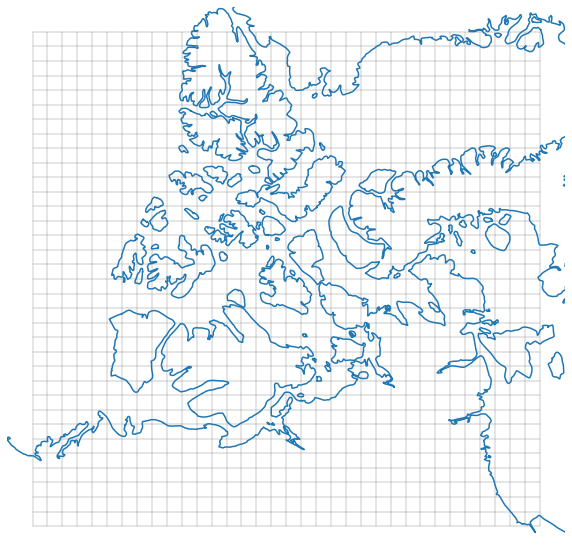

In [3]:
position = (-98,73) # lon, lat
orientation = -36 #(-0.1, 1) # east, north
L, W, Lres, Wres = 2500e3, 2500e3, 70.e3, 70.e3 # dimensions and resolution of grid (L, Lres are along orientation vector)
grid = lompe.cs.CSgrid(lompe.cs.CSprojection(position, orientation), L, W, Lres, Wres, R = 6481.2e3)

# plot grid and coastlines
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_axis_off()
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    ax.plot(xi, eta, color = 'grey', linewidth = .4)

xlim, ylim = ax.get_xlim(), ax.get_ylim()
for cl in grid.projection.get_projected_coastlines():
    ax.plot(cl[0], cl[1], color = 'C0')
    
ax.set_xlim(xlim)
ax.set_ylim(ylim);

##### Input data - Create object for auroral conductance

Define conducance model object which is made through Cmodel. This uses auroral images from SSUSI to calculate auroral conductances.

In [4]:
tempfile_path = '../sample_dataset/' # where .nc SSUSI-files are saved. You can change to fit your system.
cmod = Cmodel(grid, event, stime, spline_smoothing = 10, EUV = True, filtersize = 2, how = 'median', 
              param = 'lbhs', tempfile_path = tempfile_path, basepath = tempfile_path + '/raw/') #1000

##### Other input data

Next, we look at other data that will be input to Lompe. In this example, the files are pre-made and saved in ./sample_dataset. See Data_handling_with_lompe for explanation on how to get the data on this format.

SuperDARN data (gridfiles) is avaliable at https://doi.org/10.5281/zenodo.3618607.

SSIES DMSP F17 drift meter data is available from Madrigal.

SuperMAG data can be downloaded manually from the SuperMAG website. (API in progress.)

In [5]:
# file names
sdarnfn = tempfile_path + '20141215_superdarn_grdmap.h5'
f17fn = tempfile_path + '20141215_ssies_f17.h5'
f18fn = tempfile_path + '20141215_ssies_f18_hairston.h5'
smagfn = tempfile_path + '20141215_supermag.h5'

# load data
superdarn = pd.read_hdf(sdarnfn)
ssies17 = pd.read_hdf(f17fn)
ssies18 = pd.read_hdf(f18fn)
supermag = pd.read_hdf(smagfn)

The data must be passed to the lompe Emodel object (created later) as Lompe Data objects. The data that is passed to the Emodel object is the data that will be used in the inversion. However, the data objects above contain data from a whole day, and we may want to loop over smaller subsets. Here is a function that returns subsets of the data:

In [6]:
def get_data_subsets(t0, t1):
    """ return subsets of data loaded above, between t0 and t1 """
    
    # SuperDARN data:
    #sd = superdarn.loc[t0:t1, :]
    sd = superdarn.loc[(superdarn.index >= t0) & (superdarn.index <= t1) & 
                        (superdarn.vlos < 2000)].dropna()
    sd_vlos = sd['vlos'].values
    sd_coords = np.vstack((sd['glon'].values, sd['glat'].values))
    sd_los  = np.vstack((sd['le'].values, sd['ln'].values))
    
    # SSIES (DMSP F17) data:
    f17 = ssies17[t0 - DT : t1 + DT].dropna() # why +- TWO DT??
    v_crosstrack17 = np.abs(f17.hor_ion_v).values
    f17_coords = np.vstack((f17.glon.values, f17.gdlat.values))
    f17_los  = np.vstack((f17['le'].values, f17['ln'].values))
    
    # SSIES (DMSP F18) data:
    f18 = ssies18[t0 - DT : t1 + DT].dropna()
    v_crosstrack18 = np.abs(f18.hor_ion_v).values
    f18_coords = np.vstack((f18.glon.values, f18.glat.values))
    f18_los  = np.vstack((f18['le'].values, f18['ln'].values))
    # add large error for poor F18 measurements
    error = np.zeros(len(f18))
    error[f18.vyqual > 2] = 10000

    # SuperMAG data:
    smag = supermag[supermag.lat <= 90] # select northern hemisphere magnetometers? Necessarry?
    smag = smag[t0 : t1].dropna()
    smag_B = np.vstack((smag.Be.values, smag.Bn.values, smag.Bu.values)) # nT
    smag_coords = np.vstack((smag.lon.values, smag.lat.values))
    
    
    # Make the data objects. The scale keyword determines a weight for the dataset. Increase it to reduce weight
    # superdarn_data = lompe.Data(sd_vlos        , sd_coords  , LOS = sd_los , datatype = 'convection' , scale = 500)
    # ssies_data1    = lompe.Data(v_crosstrack17 , f17_coords , LOS = f17_los, datatype = 'convection' , scale = 500)
    # ssies_data2    = lompe.Data(v_crosstrack18 , f18_coords , LOS = f18_los, datatype = 'convection' , scale = 500   , error = error)
    # supermag_data  = lompe.Data(smag_B * 1e-9  , smag_coords,                datatype = 'ground_mag' , scale = 100e-9, error = 1e10)
    # note the large error added to SuperMAG data to produce zero weight

    #'scale' keyword deprecated in favor of 'error' and 'iweight' (importance weight) keywords
    superdarn_data = lompe.Data(sd_vlos        , sd_coords  , LOS = sd_los , datatype = 'convection' , iweight = 1.0, error = 50)
    ssies_data1    = lompe.Data(v_crosstrack17 , f17_coords , LOS = f17_los, datatype = 'convection' , iweight = 1.0, error = 50)
    ssies_data2    = lompe.Data(v_crosstrack18 , f18_coords , LOS = f18_los, datatype = 'convection' , iweight = 1.0, error = error)
    supermag_data  = lompe.Data(smag_B * 1e-9  , smag_coords,                datatype = 'ground_mag' , iweight = 0.0, error = 10e-9)
    # note the iweight=0.0 given to SuperMAG data to produce zero weight 
    
    return(superdarn_data, ssies_data1, ssies_data2, supermag_data)


We want the SuperMAG observations to be visible on the output figure, but we do not want the SuperMAG data to be used as input to the Lompe E-field model. To accomplish this, we add a large error ($10^{10}$) to the Lompe data object for SuperMAG. This way it will not have an effect on the model.

##### Run Lompe model

Now we can initialize the model, give it the input data from the speccified time interval and 

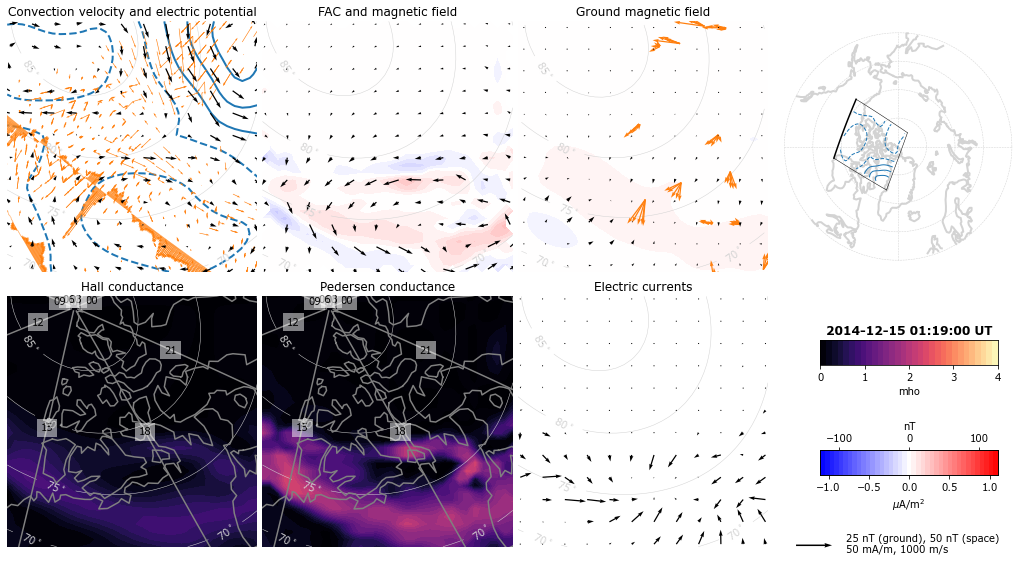

In [7]:
# get data from specified time interval:
sd_data, ssies_data1, ssies_data2, sm_data = get_data_subsets(stime - DT, stime + DT)

# apex object for plotting in magnetic
a = apexpy.Apex(stime, refh = 110)

# create Emodel object. Pass grid and Hall/Pedersen conductance from SSUSI image
model = lompe.Emodel(grid, (cmod.hall, cmod.pedersen))

# add data to model
model.add_data(sd_data, ssies_data1, ssies_data2, sm_data)

# Run inversion. l1 and l2 are regularization parameters that control the damping of 
# 1) model norm, and 2) gradient of SECS amplitudes (charges) in magnetic eastward direction
model.run_inversion(l1 = 1, l2 = 10.)

# show Lompe output
fig = lompe.lompeplot(model, include_data = True, time = stime, apex = a, 
                      colorscales = {'fac'        : np.linspace(-0.55, 0.55, 40) * 1e-6 * 2,
                                     'ground_mag' : np.linspace(-380, 380, 50) * 1e-9 / 3, # upward component
                                     'hall'       : np.linspace(0, 4, 32), # mho
                                     'pedersen'   : np.linspace(0, 4, 32)}, # mho
                        quiverscales = {'ground_mag'       : 50*1e-9, 
                                        'space_mag_fac'    : 100*1e-9, 
                                        'space_mag_full'   : 100*1e-9, 
                                        'electric_current' : 100 * 1e-3}, 
                        savekw = {'fname':'./output_figures/polar_cap_event.pdf'})

Plot the different contributions to FAC from the different terms from divergence of Ohms law:

$\nabla \cdot \mathbf{J} = \nabla \cdot \mathbf{J}^\star = \nabla \Sigma_P \cdot \mathbf{E} + \Sigma_P\nabla\cdot \mathbf{E} \mp \hat{\mathbf{u}}\cdot(\mathbf{E}\times \nabla\Sigma_H)$

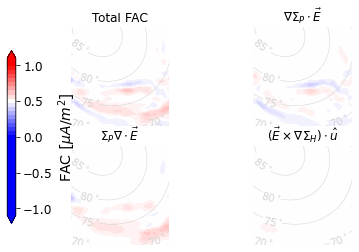

In [8]:
Ee, En = model.Ee, model.En   # model electric field design matrices. east, north
E = np.vstack((Ee, En))

# column vectors of conductance:
SH = np.ravel(model.hall_conductance()    ).reshape((-1, 1))
SP = np.ravel(model.pedersen_conductance()).reshape((-1, 1))

# combine:
d1 = -(model.De.dot(SP)*Ee + model.Dn.dot(SP)*En).dot(model.m)
d2 = -(SP*model.Ddiv.dot(E)).dot(model.m)
d3 = -(- model.Dn.dot(SH)*Ee*model.hemisphere + model.De.dot(SH)*En*model.hemisphere).dot(model.m)

fig = plt.figure()

ax = fig.add_subplot(221)
format_ax(ax, model, apex = a)
dtype='fac'
kwargs = {}
kwargs['cmap'] = plt.cm.bwr
kwargs['levels'] = COLORSCALES[dtype]*1e6
ax.contourf(grid.xi, grid.eta, (d1+d2+d3).reshape(grid.shape)*1e6, **kwargs)
ax.set_title('Total FAC')

# grad(Pedersen) dot E
ax = fig.add_subplot(222)
ax.set_title('$\\nabla \\Sigma_P \\cdot \\vec{E}$')
format_ax(ax, model, apex = a)
ax.contourf(grid.xi, grid.eta, (d1).reshape(grid.shape)*1e6, **kwargs)

# Pedersen dot div(E)
ax = fig.add_subplot(223)
ax.set_title('$\\Sigma_P \\nabla \\cdot \\vec{E}$')
format_ax(ax, model, apex = a)
ax.contourf(grid.xi, grid.eta, (d2).reshape(grid.shape)*1e6, **kwargs)

# E cross grad(Hall) dot up
ax = fig.add_subplot(224)
ax.set_title('$(\\vec{E} \\times \\nabla \\Sigma_H) \\cdot \\hat{u}$')
format_ax(ax, model, apex = a)
ax.contourf(grid.xi, grid.eta, (d3).reshape(grid.shape)*1e6, **kwargs)

ax1 = fig.add_axes([0.04, 0.2, 0.02, 0.6])
cbar = matplotlib.colorbar.ColorbarBase(ax1, cmap = kwargs['cmap'],
                                        boundaries = kwargs['levels'],
                                        ticks = np.linspace(-1, 1, 5),
                                        extend = 'both',
                                        spacing = 'uniform',
                                        orientation = 'vertical')
cbar.set_label('FAC [$\\mu A/m^2$]', size = 14)
cbar.ax.tick_params(labelsize=12) 

# FIGURE 11 IN LOMPE PAPER (Laundal et al. 2022, https://doi.org/10.1029/2022JA030356)
fig.savefig('./output_figures/polar_cap_event_fac.pdf')

The figure shows separation of the three terms contributing to the field-aligned currents (FAC), provided by the Lompe technique. Note how the Total FAC plot is the same as the FAC shown in the lompeplot figure.